# Non-linear features

This notebook demonstrates how to use YASA to calculate epoch-per-epoch non-linear features of a full-night single-channel EEG recording.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

You will also need the [entropy](https://raphaelvallat.github.io/entropy/build/html/index.html) package. Please refer to the documentation for installation instructions.

In [1]:
import yasa
import numpy as np
import pandas as pd
import entropy as ent
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

# Keep only Cz
data = data[0, :]
print(data.shape, np.round(data[0:5], 3))

(2161058,) [15.797 22.307 39.922 25.657 27.094]


In [2]:
# Load the hypnogram data
hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
print(hypno.shape, 'Unique values =', np.unique(hypno))

(720,) Unique values = [0 1 2 3 4]


In [3]:
# Convert the EEG data to 30-sec data
times, data_win = yasa.sliding_window(data, sf, window=30)

# Convert times to minutes
times /= 60

data_win.shape

(720, 3000)

## Calculate non-linear features

In [4]:
from numpy import apply_along_axis as apply

df_feat = {
    # Entropy
    'perm_entropy': apply(ent.perm_entropy, axis=1, arr=data_win, normalize=True),
    'svd_entropy': apply(ent.svd_entropy, 1, data_win, normalize=True),
    'spec_entropy': apply(ent.spectral_entropy, 1, data_win, sf=sf, nperseg=data_win.shape[1], normalize=True),
    'sample_entropy': apply(ent.sample_entropy, 1, data_win),
    # Fractal dimension
    'dfa': apply(ent.detrended_fluctuation, 1, data_win),
    'petrosian': apply(ent.petrosian_fd, 1, data_win),
    'katz': apply(ent.katz_fd, 1, data_win),
    'higuchi': apply(ent.higuchi_fd, 1, data_win),
}

df_feat = pd.DataFrame(df_feat)
df_feat.head()

,perm_entropy,svd_entropy,spec_entropy,sample_entropy,dfa,petrosian,katz,higuchi
0,0.993005,0.615179,0.506686,0.992649,1.219024,1.027226,2.794894,1.743780
1,0.993249,0.565308,0.445024,0.858924,1.324585,1.027141,2.593635,1.748034
2,0.993561,0.573424,0.502160,0.773124,1.359347,1.027254,2.633458,1.721437
3,0.998517,0.495381,0.340890,0.166400,1.431093,1.028768,2.259923,1.868283
4,0.991045,0.737926,0.605878,1.332437,1.154569,1.026600,3.484544,1.769742


In [5]:
def lziv(x):
    """Binarize the EEG signal and calculate the Lempel-Ziv complexity.
    """
    return ent.lziv_complexity(x > x.mean(), normalize=True)

df_feat['lziv'] = apply(lziv, 1, data_win)  # Slow

## Add classic spectral power

In [6]:
# Spectral power
spectral = apply(lambda x: yasa.bandpower(x, sf).iloc[0, :4], 1, data_win)
df_feat[['delta', 'theta', 'alpha', 'beta']] = pd.DataFrame(spectral, dtype=float)

In [7]:
# Ratio of spectral power
# df_feat.eval('dt = delta / theta', inplace=True)
# df_feat.eval('db = delta / beta', inplace=True)
# df_feat.eval('at = alpha / theta', inplace=True)

## Find best features for sleep stage classification

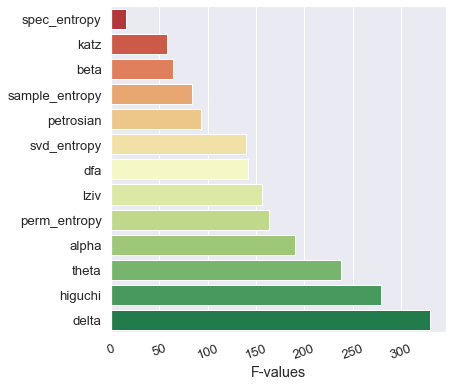

In [8]:
from sklearn.feature_selection import f_classif

# Extract sorted F-values
fvals = pd.Series(f_classif(X=df_feat, y=hypno)[0], 
                  index=df_feat.columns
                 ).sort_values()

# Plot best features
plt.figure(figsize=(6, 6))
sns.barplot(y=fvals.index, x=fvals, palette='RdYlGn')
plt.xlabel('F-values')
plt.xticks(rotation=20);

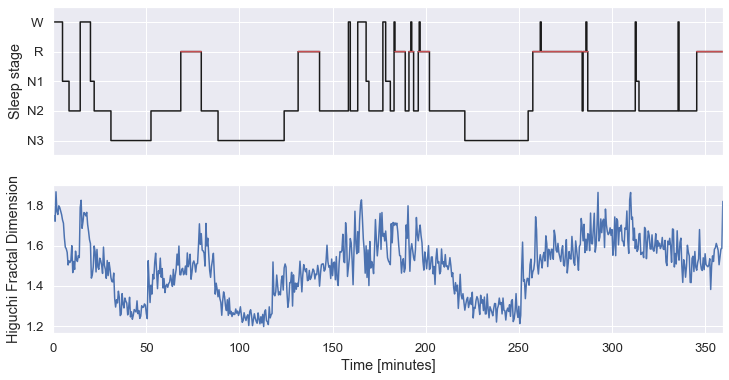

In [9]:
# Plot hypnogram and higuchi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

hypno = pd.Series(hypno).map({-1: -1, 0: 0, 1: 2, 2: 3, 3: 4, 4: 1}).values
hypno_rem = np.ma.masked_not_equal(hypno, 1)

# Plot the hypnogram
ax1.step(times, -1 * hypno, color='k')
ax1.step(times, -1 * hypno_rem, color='r')
ax1.set_yticks([0, -1, -2, -3, -4])
ax1.set_yticklabels(['W', 'R', 'N1', 'N2', 'N3'])
ax1.set_ylim(-4.5, 0.5)
ax1.set_ylabel('Sleep stage')

# Plot the non-linear feature
ax2.plot(times, df_feat['higuchi'])
ax2.set_ylabel('Higuchi Fractal Dimension')
ax2.set_xlabel('Time [minutes]')

ax2.set_xlim(0, times[-1]);